In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import datetime
import time

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.style.use('ggplot')

# 公式

In [2]:
def dd(data, position, td):
    
    principal = 1000000
    fee = 600
    
    data['point'] = data['開盤價'].diff()
    # data['point'][0] = 0
    data['profit'] = np.nan
    data['position'] = position
    data['principal'] = np.nan
    data['principal'][0] = principal

#     # 計算部位
#     for i in range(1, len(data)) :
#         if data.loc[i-1, 'position'] == 0 :
#             if data.loc[i-1, 'sig'] == 1 :
#                 data.loc[i, 'position'] = 1
#             if data.loc[i-1, 'sig'] == 0 :
#                 data.loc[i, 'position'] = 0
#             if data.loc[i-1, 'sig'] == -1 :
#                 data.loc[i, 'position'] = 0

#         if data.loc[i-1, 'position'] == 1 :
#             if data.loc[i-1, 'sig'] == 1 :
#                 data.loc[i, 'position'] = 1
#             if data.loc[i-1, 'sig'] == 0:
#                 data.loc[i, 'position'] = 1
#             if data.loc[i-1, 'sig'] == -1 :
#                 data.loc[i, 'position'] = 0

    #計算損益

    for i in range(1, len(data)):
        if (data['position'][i-1] == 0) & (data['position'][i] == 0):
            data['principal'][i] = data['principal'][i-1]
            #有買進要扣手續類
        elif (data['position'][i-1] == 0) & (data['position'][i] == 1):
            data['profit'][i] = (-fee)
            data['principal'][i] = data['principal'][i-1] + (data['position'][i]*data['profit'][i])
        elif (data['position'][i-1] == 1) & (data['position'][i] == 1):
            #轉倉要要扣手續費
            if data['date'][i] in np.array(td):
                data['profit'][i] = data['point'][i]*200 - fee
                data['principal'][i] = data['principal'][i-1] + (data['position'][i]*data['profit'][i])
            else : 
                data['profit'][i] = data['point'][i]*200

                data['principal'][i] = data['principal'][i-1] + (data['position'][i]*data['profit'][i])

            #有賣出要扣手續費
        elif (data['position'][i-1] == 1) & (data['position'][i] == 0):
            data['profit'][i] = (data['point'][i]*200 * data['position'][i-1]) - fee
            data['principal'][i] = data['principal'][i-1]+ (data['position'][i-1]*data['profit'][i])

    #畫圖用資料        
    data['high'] = data['principal'].cummax()
    data['dd'] = ((data['principal']-data['high']))/data['high']

    return data

In [3]:
def performance(data):
    
    principal = 1000000
    
    if ((data['position'][data.index[-2]] == 1) & ((data['position'][data.index[-1]] == 1))) or ((data['position'][data.index[-2]] == 1) & ((data['position'][data.index[-1]] == 0))):
        Return = np.round(((data['principal'][data.index[-2]] - principal)/principal), 4)
    else :
        Return = np.round(((data['principal'][data.index[-1]] - principal)/principal), 4)
        
    MDD = np.round((-data['dd'].min()), 4)
    ret_to_MDD = np.round(Return/MDD, 2)
    
    #sp
    
    # ret_list = [0]
    # for i in range(1, len(data)):
    #     if data['principal'][i] != data['principal'][i-1]:
    #         ret_list.append((data['principal'][i]-data['principal'][i-1])/data['principal'][i-1])
            
    ret_list = data['principal'].pct_change()

    mean_ret = np.mean(ret_list)*252
    std = (np.std(ret_list)*(252**0.5))
    sp = round((mean_ret / std), 4)

    
    per = {"Return" : Return, "MDD" : MDD, "Return to MDD" : ret_to_MDD, "Sharpe Ratio" : sp}
    
    return per

In [4]:
def plot(data, dictionary, name) :

    #new equity high
    eh = data[['date', 'high']]
    eh = eh.drop_duplicates('high', keep = 'first')
                            
    fig = plt.figure(figsize=(14, 6)) 
    plt.subplot(2, 1, 1)
    plt.grid(color = 'white')
    plt.title('{} Return&MDD'.format(name),fontsize=20)
    plt.plot(data['date'], data['principal'], color = 'red')
    plt.plot(eh['date'], eh['high'],'o',color = 'limegreen', alpha = 0.5)
    plt.legend(['Gain' , 'New equity high'], loc = 'best')
    plt.text(data['date'][data.index[-200]], data['principal'].min(), 'Return: {}'.format(dictionary['Return'])+\
                                                                 "\nMDD: {}".format(dictionary['MDD'])+\
                                                                 "\nReturn to MDD: {}".format(dictionary['Return to MDD'])+\
                                                                 "\nSharpe Ratio: {}".format(dictionary['Sharpe Ratio']), fontsize = 10, color='black')
    # plt.axvline(x = pd.to_datetime("2020-01-01"), color = "grey")  
    
    plt.subplot(2, 1, 2)
    plt.grid(color = 'white')
    plt.fill_between(data['date'], data['dd'], interpolate=True, color='red')
    plt.legend(['dd'], loc = 'upper left')
    # plt.axvline(x = pd.to_datetime("2020-01-01"), color = "grey")
    
    plt.show()

In [5]:
def get_year(date):
    
    y = []
    
    for i in range(len(date)):
        oneday = date[i]
        year = oneday.year
        y.append(year)
        
    return y

In [6]:
def get_month(date):
    
    m = []
    
    for i in range(len(date)):
        oneday = date[i]
        month = oneday.month
        m.append(month)
        
    return m

# 商品資料

In [7]:
# index =  pd.read_csv("D:\TMBA\加權指數.csv")
# index = index[['date', 'close']]
# index['date'] = pd.to_datetime(index['date'])

In [8]:
future = pd.read_csv("D:\TMBA\期貨日成交資訊.csv", low_memory = True)
future = future[future['交易時段'] == "position"]
future['日期'] = pd.to_datetime(future['日期'])
# future = future[['日期', '開盤價', '收盤價']]
# future.columns = ['date', '開盤價', 'close_f']
# future.tail(10)

## 轉倉

In [9]:
sett = pd.read_csv("D:\TMBA\結算日.csv", encoding = 'ANSI')
sett['最後結算日'] = pd.to_datetime(sett['最後結算日'])

for i in range(len(sett)):
    if len(sett['契約月份'][i]) != 6:
        sett = sett.drop(i, axis = 0)
        
sett = sett['最後結算日']

In [10]:
# #計算逆價差要的表格
# df = pd.merge(index, future, on ='date', how = 'inner')
# df = df[df['date'] < '2020-01-01']
# df['spread'] = df['close_f']-df['close']

In [11]:
# # 逆價差
# for i in range(0, 8):
#     sett1 = sett
#     sett2 = sett1 - datetime.timedelta(i)
#     sett3 = pd.concat([sett, sett2], axis = 0).sort_values().reset_index().drop("index", axis = 1)
    
#     df1 = df.copy()
#     df1 = df1[df1['date'].isin(sett3)]
    
#     print(i, df1['spread'].sum(), df1['spread'].quantile(0.05))

In [12]:
#結算當天&最後結算日的日期
sett2 = sett - datetime.timedelta(0)
sett = pd.concat([sett, sett2], axis = 0).sort_values().reset_index().drop("index", axis = 1)

In [13]:
#結算當天到最後結算日的資料 
s = pd.DataFrame()
for i in range(1, len(sett), 2):
    
    f1 = future.copy()
    
    f2 = f1[(f1['日期'] >= sett['最後結算日'][i-1]) & (f1['日期'] <= sett['最後結算日'][i])]
    s = pd.concat([s, f2], axis = 0)

s = s.reset_index().drop("index", axis = 1)

In [14]:
# #平倉後的資料
# s['year'] = get_year(s['日期'])
# s['month'] = get_month(s['日期'])
# s1 = s.copy()
# s11 = s.copy()

# s2 = s.copy()
# s3 = s.copy()
# s4 = s.copy()

# for i in range(len(s)):
    
#     sit1 = s1['到期月份'][i] != (str(s1['year'][i]) + "0" + str(s1['month'][i]))
    
#     sit2 = s2['到期月份'][i] != (str(s2['year'][i]) + "0" + str(s2['month'][i]+1))
    
#     #9月跨到年底
#     if s3['month'][i] == 9 or 10 or 11 :
#         sit11 = s1['到期月份'][i] != (str(s1['year'][i]) + str(s1['month'][i]))
#         sit3 = s3['到期月份'][i] != (str(s3['year'][i]) + str(s3['month'][i]+1))
        
#     #12月跨到隔年1月有問題    
#     if s4['month'][i] == 12 :
#         sit4 = (s4['到期月份'][i] != (str(s4['year'][i]+1) + "01"))


#     if (sit1):
#         s1 = s1.drop(i, axis = 0)
#     if (sit11) :
#         s11 = s11.drop(i, axis = 0)
#     if (sit2):
#         s2 = s2.drop(i, axis = 0)
#     if (sit3) : 
#         s3 = s3.drop(i, axis = 0)
#     if (sit4) :
#         s4 = s4.drop(i, axis = 0)

In [15]:
s['year'] = get_year(s['日期'])
s['month'] = get_month(s['日期'])
s1 = s.copy()
s2 = s.copy()

for i in range(len(s)):
    
    if s1['到期月份'][i] != (str(s1['year'][i]) + "0" + str(s1['month'][i])):
        s1 = s1.drop(i, axis = 0)
    
    if s2['到期月份'][i] != (str(s2['year'][i]) + "0" + str(s2['month'][i]+1)):
        s2 = s2.drop(i, axis = 0)

s1 = s1[s1['日期'].isin(sett2)]

In [16]:
s11 = s.copy()
s11 = s[(s['month'] == 10) | (s['month'] == 11) | (s['month'] == 12)].reset_index(drop=True)

for i in range(len(s11)):
    if s11['到期月份'][i] != (str(s11['year'][i]) + str(s11['month'][i])):
            s11 = s11.drop(i, axis = 0)

s11 = s11[s11['日期'].isin(sett2)]

In [17]:
s3 = s.copy()
s3 = s[(s['month'] == 9) | (s['month'] == 10) | (s['month'] == 11)].reset_index(drop=True)

for i in range(len(s3)):
     if s3['到期月份'][i] != (str(s3['year'][i]) + str(s3['month'][i]+1)):
            s3 = s3.drop(i, axis = 0)

In [18]:
s4 = s.copy()
s4 = s[s['month']==12].reset_index(drop=True)

for i in range(len(s4)):
    if s4['到期月份'][i] != (str(s4['year'][i]+1) + "01"):
        s4 = s4.drop(i, axis = 0)

In [19]:
ss = pd.concat([s1, s11], axis = 0)
ss = pd.concat([ss, s2], axis = 0)
ss = pd.concat([ss, s3], axis = 0)
ss = pd.concat([ss, s4], axis = 0).sort_values('日期')

In [20]:
#轉倉資料併其他資料
f1 = f1.drop_duplicates("日期", keep = 'first').reset_index(drop = True)
f1 = f1[~f1['日期'].isin(ss['日期'])]

data = pd.concat([f1, ss], axis = 0).sort_values(['日期', '到期月份']).reset_index(drop = True)
data = data.rename(columns = {"日期" : 'date'})

In [21]:
# data.to_csv(r"D:\TMBA\111-1\轉倉資料.csv", index = False, encoding = 'utf-8-sig')

# 因子資料

In [31]:
# ms = pd.read_csv("D:\實習\統一期貨\工作\台股空頭因子\融資融券.csv")
ms = pd.read_csv("D:\TMBA\整體市場融資融劵表.csv")
# inst = pd.read_csv("D:\實習\統一期貨\工作\台股空頭因子\三大法人.csv")
vix = pd.read_csv("D:\TMBA\VIX_History.csv")
data_set = [ms, vix]

for i in data_set:
    i['date'] = pd.to_datetime(i['date'])

In [32]:
#券資比
mp = ms[ms['name'] == 'MarginPurchase'].reset_index().drop('index', axis = 1)
ss = ms[ms['name'] == 'ShortSale'].reset_index().drop('index', axis = 1)

r = pd.DataFrame()
r['date'] = mp['date']
r['ratio'] = ss[['TodayBalance']] / mp[['TodayBalance']]

In [ ]:
# num = pd.read_csv("D:\TMBA\家數資料.csv")
# num['date'] = pd.to_datetime(num['date'])

In [ ]:
# #法人買賣超
# local = inst[inst['name'] == 'Investment_Trust']
# local['delta_l'] = local['buy'] - local['sell']
# local = local[["date", "name", "buy", "sell", "delta_l"]].reset_index().drop('index', axis = 1)

# foreign = inst[inst['name'] == 'Foreign_Investor']

In [33]:
vix = vix[['date', 'CLOSE']]
vix.columns = ['date', 'vix_close']

# 樣本內最佳化

In [ ]:
# # 參數最佳化
# vv = pd.DataFrame()   

# for k in range(10, 31):
#     for z in np.arange(10, 31) : 
#         data1 = data.copy()
#         data1 = data1[data1['date'] <= "2019-12-31"]

#         r['percentile'] = r['ratio'].rolling(k).mean()

#         vix['mean_vix'] = vix['vix_close'].rolling(z).mean()

#         data1 = pd.merge(data1, r, on = 'date', how = 'left')
#         data1 = pd.merge(data1, vix, on = 'date', how = 'left')

#         pos = [0, 0, 0]
#         # buy_date = []
#         buy_price = [0]
#         # sell_date = []
#         # sell_price = [0]

#         for i in range(2, len(data1)-1):

#             if (pos[-2] == 0) & (pos[-1] == 1) :
#         #         buy_date.append(data1['date'][i])
#                 buy_price.append(data1['開盤價'][i])


#             #進場條件
#             a = data1['vix_close'][i] < data1['mean_vix'][i]
#             b = (data1['ratio'][i] < data1['percentile'][i])

#             #出場條件
#             c = data1['vix_close'][i] > data1['mean_vix'][i]
#             d = (data1['ratio'][i] > data1['percentile'][i])
#             e = (data1['開盤價'][i] < buy_price[-1]*0.97)

#             #結算日不做進出場
#             f = (data1['date'][i] not in np.array(sett2))

#             #沒有持有部位的情況下
#             if pos[-1] == 0 :
#                 if (a&b&f) == True :
#                     pos.append(pos[-1] + 1)
#                 else :
#                     pos.append(pos[-1])

#             #在持有部位的情況下
#             elif pos[-1] == 1 :
#                 if (c&d&f) :
#                      pos.append(pos[-1] - 1)
#                 elif (e&f) : 
#                     pos.append(pos[-1] - 1)
#                     # sell_date.append(data1['date'][i])
#         #             sell_price.append(data1['開盤價'][i])
#                 else :
#                     pos.append(pos[-1])


#         data1 = dd(data1, pos, sett2)

#         if ((data1['position'][data1.index[-2]] == 1) & ((data1['position'][data1.index[-1]] == 1))) or ((data1['position'][data1.index[-2]] == 1) & ((data1['position'][data1.index[-1]] == 0))) :
#             Return = np.round(((data1['principal'][data1.index[-2]] - 100000)/100000), 4)*100
#         else :
#             Return = np.round(((data1['principal'][data1.index[-1]] - 100000)/100000), 4)*100

#         MDD = round((-data1['dd'].min()), 4)*100
#         ret_to_MDD = (np.round(Return/MDD, 4))

#         print(k, z, ret_to_MDD)
#         per = {"day_ratio" : k, "day_vix" : z, "ret" : Return, "MDD" : MDD, "rm" : ret_to_MDD}
#         vv = vv.append(per, ignore_index = True)

In [ ]:
# vv = pd.read_csv("D:\TMBA\opt2.csv", encoding = 'utf-8')

# std_ret = round(np.std(vv['ret']), 4)
# std_mdd = round(np.std(vv['MDD']), 4)
# std_rm = round(np.std(vv['rm']), 4)

# print('std_ret: {}'.format(std_ret)+\
#         "\nstd_mdd: {}".format(std_mdd)+\
#         "\nstd_rm: {}".format(std_rm))

In [ ]:
# from tkinter import Y
# from mpl_toolkits.mplot3d import axes3d


# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(projection='3d')

# x = np.reshape(list(vv['day_ratio']), (21, 21))
# y = np.reshape(list(vv['day_vix']), (21, 21))
# z = np.reshape(list(vv['rm']), (21, 21))

# ax.set_title("Return to MDD", fontsize= 15)
# ax.plot_surface(x, y, z, cmap = "twilight")
# ax.set_xlabel("M days", fontsize = 10)
# ax.set_ylabel("N days", fontsize = 10)
# # ax.set_zlabel("Return to MDD", fontsize = 10)

# plt.show()

In [ ]:
# fig = plt.figure(figsize=(14,10)) 
# plt.grid(color = 'white')


# plt.subplot(3, 3, 1)
# bins = np.linspace(39, 134, 50)
# plt.hist(vv['ret'], bins, color = "blue")
# plt.axvline(np.mean(vv['ret']), color = 'red')
# plt.axvline((np.mean(vv['ret'])+std_ret), color = 'black')
# plt.axvline((np.mean(vv['ret'])-std_ret), color = 'black')
# plt.xlabel("Return")
# plt.ylabel("counts")

# plt.subplot(3, 3, 2)
# plt.title('optimization data')
# bins = np.linspace(19, 50, 50)
# plt.hist(vv['MDD'], bins, color = "blue")
# plt.axvline(np.mean(vv['MDD']), color = 'red')
# plt.axvline((np.mean(vv['MDD'])+std_mdd), color = 'black')
# plt.axvline((np.mean(vv['MDD'])-std_mdd), color = 'black')
# plt.xlabel("MDD")

# plt.subplot(3, 3, 3)
# bins = np.linspace(0.8, 6.3, 50)
# plt.hist(vv['rm'], bins, color = "blue")
# plt.axvline(np.mean(vv['rm']), color = 'red')
# plt.axvline((np.mean(vv['rm'])+std_rm), color = 'black')
# plt.axvline((np.mean(vv['rm'])-std_rm), color = 'black')
# plt.xlabel("Return to MDD")

# plt.show()

# 樣本外

In [34]:
##輸入最佳參數組合
r['percentile'] = r['ratio'].rolling(13).mean()
vix['mean_vix'] = vix['vix_close'].rolling(20).mean()
# foreign['acc_delta'] = (foreign['buy'] - foreign['sell']).rolling(30).sum()
# foreign = foreign[["date", "name", "buy", "sell", "acc_delta"]].reset_index().drop('index', axis = 1)

C:\Users\User\AppData\Local\Temp\ipykernel_25004\1913962609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix['mean_vix'] = vix['vix_close'].rolling(20).mean()


In [35]:
data = pd.merge(data, r, on = 'date', how = 'left')
# data = pd.merge(data, por, on = 'date', how = 'outer')
data = pd.merge(data, vix, on = 'date', how = 'left')
# data = pd.merge(data, num, on = 'date', how = 'left')

data = data[data['date'] >= "2010-01-01"].reset_index(drop = True)
# data = data[(data['date'] >= "2012-01-01") & (data['date'] <= "2014-01-01")].reset_index(drop = True)

In [ ]:
# fig = plt.figure(figsize=(14, 6)) 
# plt.grid(color = 'white')

# plt.subplot(3, 1, 1)
# plt.title('Data Info', fontsize=20)
# plt.plot(data['date'], data['開盤價'], color = 'black')
# plt.legend(["open"])

# plt.subplot(3, 1, 2)
# plt.plot(data['date'], data['vix_close'], color = "blue")
# plt.plot(data['date'], data['mean_vix'], color = "red")
# plt.legend(["vix", 'vix_mean'], loc = 'upper left')

# plt.subplot(3, 1, 3)
# plt.bar(data['date'], data['ratio'], color = "green")
# plt.plot(data['date'], data['percentile'], color = "purple")
# plt.legend(["ratio_mean", 'ratio'], loc = 'upper left')

# plt.show()

In [36]:
#不加碼版本
#計算部位
pos = [0, 0, 0]
buy_date = []
buy_price = [0]
sell_date = []
# sell_price = [0]

for i in range(2, len(data)-1):
    
    if (pos[-2] == 0) & (pos[-1] == 1) :
        buy_date.append(data['date'][i])
        buy_price.append(data['開盤價'][i])
    
    
    #進場條件
    a = data['vix_close'][i] < data['mean_vix'][i]
    b = (data['ratio'][i] < data['percentile'][i])
    
    #出場條件
    c = data['vix_close'][i] > data['mean_vix'][i]
    d = (data['ratio'][i] > data['percentile'][i])
    e = (data['開盤價'][i] < buy_price[-1]*0.97)
    
    #結算日隔一天不做進出場
    f = (data['date'][i] not in np.array(sett2))
    
    #沒有持有部位的情況下
    if pos[-1] == 0 :
        if (a&b&f) == True :
            pos.append(pos[-1] + 1)
        else :
            pos.append(pos[-1])
                
    #在持有部位的情況下
    elif pos[-1] == 1 :
        if (c&d&f) :
            pos.append(pos[-1] - 1)
        elif (e&f) : 
            pos.append(pos[-1] - 1)
            sell_date.append(data['date'][i+1])
#             sell_price.append(data['開盤價'][i])
        else :
            pos.append(pos[-1])

In [37]:
data = dd(data, pos, sett2)

C:\Users\User\AppData\Local\Temp\ipykernel_25004\2548489721.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['principal'][0] = principal
C:\Users\User\AppData\Local\Temp\ipykernel_25004\2548489721.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['principal'][i] = data['principal'][i-1]
C:\Users\User\AppData\Local\Temp\ipykernel_25004\2548489721.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['profit'][i] = (

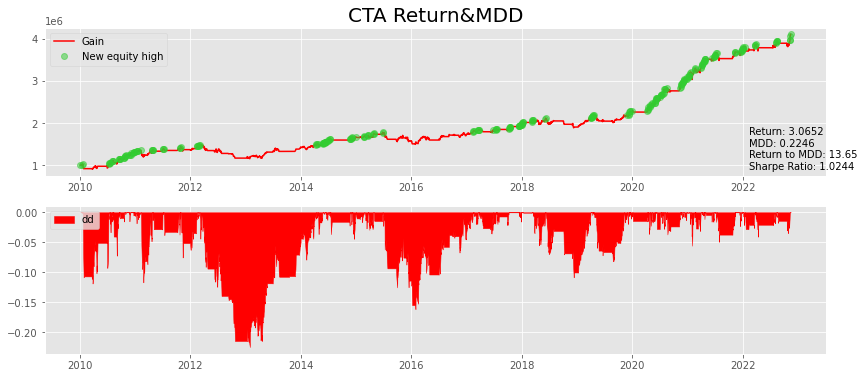

In [38]:
plot(data, performance(data), 'CTA')

In [39]:
data.tail(50)

,date,期貨代碼,到期月份,開盤價,最高價,最低價,收盤價,漲跌幅,漲跌幅比例,成交量,結算價,未沖銷契約量,交易時段,year,month,ratio,percentile,vix_close,mean_vix,point,profit,position,principal,high,dd
3270,2022-09-06,TX,202209,14720,14770,14555,14634,21,0.14,93184,14635,74574,position,NaN,NaN,0.084197,0.083212,26.91,22.9730,130.0,NaN,0,3894000.0,3950000.0,-0.014177
3271,2022-09-07,TX,202209,14445,14455,14331,14359,-276,-1.89,99373,14357,75051,position,NaN,NaN,0.084495,0.083340,24.64,23.2180,-275.0,NaN,0,3894000.0,3950000.0,-0.014177
3272,2022-09-08,TX,202209,14459,14552,14389,14548,191,1.33,88563,14545,70703,position,NaN,NaN,0.086866,0.083687,23.61,23.3885,14.0,NaN,0,3894000.0,3950000.0,-0.014177
3273,2022-09-12,TX,202209,14775,14824,14731,14794,249,1.71,73967,14797,68152,position,NaN,NaN,0.085246,0.083936,23.87,23.7475,316.0,NaN,0,3894000.0,3950000.0,-0.014177
3274,2022-09-13,TX,202209,14884,14928,14827,14875,78,0.53,64810,14875,66793,position,NaN,NaN,0.087068,0.084173,27.27,24.1265,109.0,NaN,0,3894000.0,3950000.0,-0.014177
3275,2022-09-14,TX,202209,14458,14641,14443,14577,-298,-2.00,88778,14578,66290,position,NaN,NaN,0.085250,0.084268,26.16,24.4395,-426.0,NaN,0,3894000.0,3950000.0,-0.014177
3276,2022-09-15,TX,202209,14578,14715,14562,14642,64,0.44,77473,14642,67005,position,NaN,NaN,0.085467,0.084334,26.27,24.7750,120.0,NaN,0,3894000.0,3950000.0,-0.014177
3277,2022-09-16,TX,202209,14500,14527,14465,14483,-159,-1.09,75293,14485,65353,position,NaN,NaN,0.085330,0.084530,26.30,25.0600,-78.0,NaN,0,3894000.0,3950000.0,-0.014177
3278,2022-09-19,TX,202209,14550,14579,14406,14420,-65,-0.45,96859,14420,48006,position,NaN,NaN,0.085816,0.084764,25.76,25.1580,50.0,NaN,0,3894000.0,3950000.0,-0.014177
3279,2022-09-20,TX,202209,14548,14569,14464,14561,141,0.98,83214,14558,26745,position,NaN,NaN,0.086547,0.085023,27.16,25.3105,-2.0,NaN,0,3894000.0,3950000.0,-0.014177


In [ ]:
principal = 1000000

if ((data['position'][data.index[-2]] == 1) & ((data['position'][data.index[-1]] == 1))) or ((data['position'][data.index[-2]] == 1) & ((data['position'][data.index[-1]] == 0))) :
    Return = np.round(((data['principal'][data.index[-2]] - principal)/principal), 4)*100
else :
    Return = np.round(((data['principal'][data.index[-1]] - principal)/principal), 4)*100

MDD = np.round((-data['dd'].min()), 4)*100
ret_to_MDD = (np.round(Return/MDD, 2))
    
trade_price = []
date = []

for i in range(1, len(data)):
    if (data['position'][i-1] == 0) & (data['position'][i] == 1):
        trade_price.append(data['principal'][i-1])
        date.append(data['date'][i])
    if (data['position'][i-1] == 1) & (data['position'][i] == 0) :
        trade_price.append(data['principal'][i])
        date.append(data['date'][i])

trade = pd.DataFrame(date, columns = ['date'])
trade['principal'] = trade_price

#sp


# ret_list = [0]
# for i in range(1, len(data)):
#     if data['principal'][i] != data['principal'][i-1]:
#         ret_list.append((data['principal'][i]-data['principal'][i-1])/data['principal'][i-1])
        
ret_list = data['principal'].pct_change()
mean_ret = (np.mean(ret_list))*252
std = (np.std(ret_list)*(252**0.5))
sp = np.round((mean_ret / std), 4)

#確定是否算對 
trade_point = []

for i in range(1, len(trade), 2):
    trade_point.append(round((trade['principal'][i]-trade['principal'][i-1]), 2))
#         mean_ret = round(sum(trade_ret)/len(trade_ret), 3)
#         sigma = round(np.std(trade_ret), 4)

#毛利毛損
gp = 0
gl = 0

for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        gp += trade_point[i]
    elif trade_point[i] < 0:
        gl += trade_point[i]
    
pf = round((-gp/gl), 4)

#勝率和交易次數
win = 0    
loss = 0
for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        win += 1
    else :
        loss +=1
trade_times = win+loss
    
if trade_times == 0 :
    win_rate = 0
elif trade_times != 0 :    
    win_rate = round(win/(trade_times), 2)


#平均持有時間
day = []

for i in range(1, len(trade), 2):
    date1 = datetime.datetime.strptime(str(trade['date'][i-1])[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str(trade['date'][i])[0:10], "%Y-%m-%d")
    num = (date2 - date1).days
    day.append(num)
    mean_day = np.round(np.mean(day), 2)

print('Return: {}%'.format(Return) +\
          "\nMDD: {}%".format(MDD) +\
          "\nReturn to MDD: {}".format(ret_to_MDD) +\
          "\nSharpe Ratio: {}".format(sp)+\
          "\nprofit factor: {}".format(pf) +\
          "\ntimes: {}".format(trade_times) +\
          "\nwin rate: {}".format(win_rate) +\
          "\nmean day: {}".format(mean_day))

Return: 289.40000000000003%
MDD: 22.46%
Return to MDD: 12.89
Sharpe Ratio: 0.9927
profit factor: 3.753
times: 73
win rate: 0.67
mean day: 32.86


In [ ]:
data.tail(100)

,date,期貨代碼,到期月份,開盤價,最高價,最低價,收盤價,漲跌幅,漲跌幅比例,成交量,結算價,未沖銷契約量,交易時段,year,month,ratio,percentile,vix_close,mean_vix,point,profit,position,principal,high,dd
3220,2022-06-30,TX,202207,14931,14945,14610,14622,-394,-2.62,131995,14624,101028,position,2022,NaN,0.068301,0.063912,28.71,28.5360,-89.0,NaN,0,3787000.0,3867200.0,-0.020739
3221,2022-07-01,TX,202207,14656,14702,14128,14175,-449,-3.07,183609,14175,98792,position,2022,NaN,0.071823,0.064902,26.70,28.6315,-275.0,NaN,0,3787000.0,3867200.0,-0.020739
3222,2022-07-04,TX,202207,14236,14312,14025,14152,-23,-0.16,143173,14152,97788,position,2022,NaN,0.074408,0.065907,27.53,28.7545,-420.0,NaN,0,3787000.0,3867200.0,-0.020739
3223,2022-07-05,TX,202207,14350,14430,13975,14231,79,0.56,175274,14209,94173,position,2022,NaN,0.074357,0.066724,27.54,28.9305,114.0,NaN,0,3787000.0,3867200.0,-0.020739
3224,2022-07-06,TX,202207,14213,14239,13858,13871,-338,-2.38,150712,13879,91327,position,2022,NaN,0.074671,0.067641,26.73,29.0690,-137.0,NaN,0,3787000.0,3867200.0,-0.020739
3225,2022-07-07,TX,202207,14068,14295,13832,14176,297,2.14,158050,14187,85116,position,2022,NaN,0.071638,0.068324,26.08,29.0685,-145.0,NaN,0,3787000.0,3867200.0,-0.020739
3226,2022-07-08,TX,202207,14390,14485,14264,14329,142,1.00,139319,14332,80103,position,2022,NaN,0.070790,0.068923,24.64,28.9130,322.0,NaN,0,3787000.0,3867200.0,-0.020739
3227,2022-07-11,TX,202207,14467,14496,14229,14276,-56,-0.39,120320,14278,76109,position,2022,NaN,0.071956,0.069525,26.17,28.5205,77.0,NaN,0,3787000.0,3867200.0,-0.020739
3228,2022-07-12,TX,202207,14157,14181,13850,13914,-364,-2.55,127127,13914,79696,position,2022,NaN,0.074784,0.070351,27.29,28.2505,-310.0,NaN,0,3787000.0,3867200.0,-0.020739
3229,2022-07-13,TX,202207,14240,14356,14203,14277,363,2.61,112460,14281,75454,position,2022,NaN,0.074141,0.070996,26.82,28.1105,83.0,NaN,0,3787000.0,3867200.0,-0.020739


C:\Users\User\AppData\Local\Temp\ipykernel_32020\2207762227.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['profit'] = trade_point


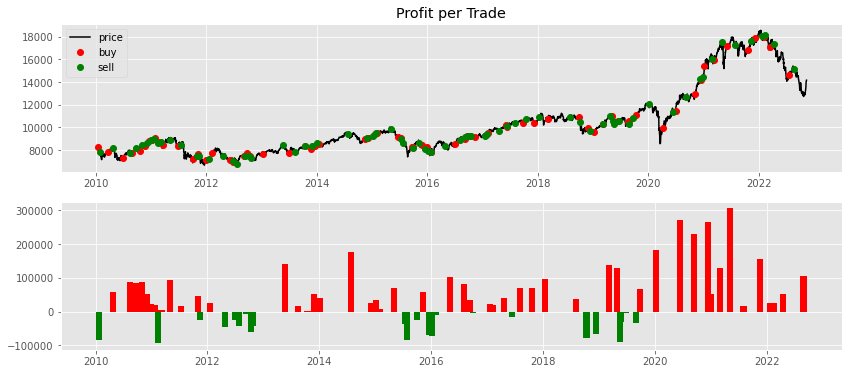

In [ ]:
# 買賣訊號
buy_mark = [np.nan]
sell_mark = [np.nan]
for i in range(1, len(data)):
    if (data['position'][i-1] == 0) & (data['position'][i] == 1):
        buy_mark.append(data['開盤價'][i])
    else :
        buy_mark.append(np.nan)
            
for i in range(1, len(data)) : 
    if (data['position'][i-1] == 1) & (data['position'][i] == 0):
        sell_mark.append(data['開盤價'][i])
    else :
        sell_mark.append(np.nan)

#每次損益
a = trade.iloc[1::2]
a['profit'] = trade_point
a = a.reset_index(drop=True)

gain = a[a['profit'] > 0]
loss = a[a['profit'] < 0]

#畫圖
fig = plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.title('Profit per Trade')
plt.plot(data['date'], data['開盤價'], color = 'black')
plt.plot(data['date'], buy_mark, 'o', color='red', alpha = 1)
plt.plot(data['date'], sell_mark, 'o', color='green', alpha = 1)
plt.legend(['price', 'buy' , 'sell'], loc = 'best')

plt.subplot(2, 1, 2)
plt.bar(gain['date'], gain['profit'], 40, align='center', color='r')
plt.bar(loss['date'], loss['profit'], 40, align='center', color='g')
plt.show()

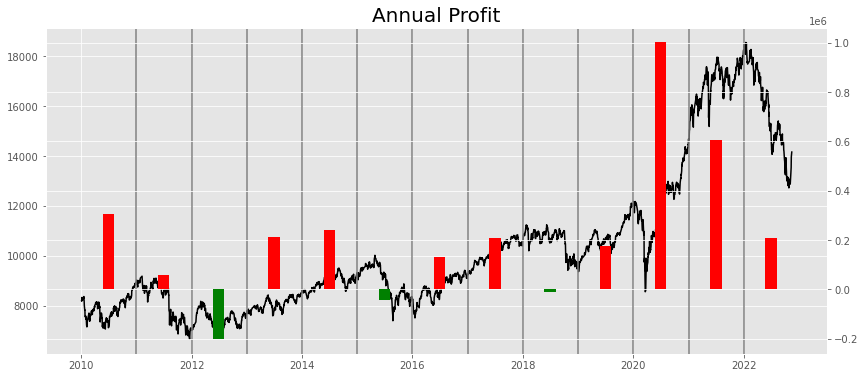

In [ ]:
#不同市場下的損益
a['year'] = get_year(a['date'])
a['month'] = get_month(a['date'])

profit_year = a[['date', 'profit']].groupby(pd.Grouper(key="date", freq="YS")).sum()
profit_year_gain = profit_year[profit_year['profit'] > 0]
profit_year_loss = profit_year[profit_year['profit'] < 0]

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.grid(color = 'white')
plt.title('Annual Profit', fontsize=20)

ax2 = ax1.twinx()

ax1.plot(data['date'], data['開盤價'], color = 'black')

for i in profit_year.index[1:] : 
    ax1.axvline(x = i, color = "grey")  
ax1.tick_params(axis='y')


ax2.bar(profit_year_gain.index + datetime.timedelta(180) , profit_year_gain['profit'], 75,align='center', color='r')
ax2.bar(profit_year_loss.index + datetime.timedelta(180), profit_year_loss['profit'], 75, align='center', color='g')
ax2.tick_params(axis='y')

plt.show()

# 績效過程

In [ ]:
#績效過程
data['year'] = get_year(data['date'])
process = []

for i in range(1, len(data)):
    if i == 1 :
        process.append(data['date'][i])
    elif data['year'][i] != data['year'][i-1]:
        process.append(data['date'][i-1])
        # process.append(data['date'][i])
    elif i == (len(data)-1):
        process.append(data['date'][i])

b = data[data['date'].isin(process)].reset_index(drop= True)
pr = b['principal'].pct_change()
pr

0          NaN
1     0.307000
2     0.045142
3    -0.146852
4     0.227218
5     0.164313
6    -0.062455
7     0.101845
8     0.135914
9    -0.026510
10    0.189255
11    0.360799
12    0.219270
13    0.037459
Name: principal, dtype: float64

In [ ]:
year_list = [2011]
for i in b['year']:
    if i != year_list[-1]:
        year_list.append(i)

pm = []
for i in year_list:
    year_df = data[data['year'] == i]
    Mdd = round(-(year_df['dd'].min()), 4)
    pm.append(Mdd)
pm

[0.1168,
 0.1187,
 0.1168,
 0.2145,
 0.2246,
 0.079,
 0.1252,
 0.1613,
 0.0354,
 0.1084,
 0.1006,
 0.037,
 0.0557,
 0.0407]

In [ ]:
#每年交易次數
a.groupby("year").count()['date']

year
2010    7
2011    7
2012    7
2013    4
2014    3
2015    8
2016    7
2017    6
2018    4
2019    7
2020    5
2021    4
2022    4
Name: date, dtype: int64

In [ ]:
# data['point'] = (data['開盤價']- data['開盤價'].shift(1)).shift(-1)
# data['profit'] = 0
# data['sig']  = sig2
# data['position'] = 0
# data['principal'] = np.nan
# data['principal'][0] = 100000
# data[['date', '開盤價', 'point', 'sig', 'position', 'profit', 'principal']].head(200)

In [ ]:
# sig2 = [0]

# for i in range(1, len(data)):
            
            
# #     a = (data['acc_delta'][i] > 0 )
#     b = data['vix_close'][i] < data['mean_vix'][i]
# #     c = (data['delta_l'][i] > 0)  
# #     d = (data['delta_f'][i-1] < 0)  
#     e = (data['ratio'][i] < data['percentile'][i])
#     f = (data['ratio'][i] > data['percentile'][i])
# #     g = (data['delta_f'][i] < 0)
#     h = data['vix_close'][i] > data['mean_vix'][i]
# #     x =  data['vix_close'][i] > data['upper'][i]
# #     y = (data['acc_delta'][i] < 0)


# #     sit1 = (data['date'][i] not in np.array(sett2))
#     sit1 = (data['date'][i] in np.array(sett2))
    
#     #轉倉日不做進出場
#     if sit1 == True:
#         sig2.append(0)
#     elif (b&e) == True:
#         sig2.append(1)
#     elif (h&f)  == True:
#         sig2.append(-1)
#     else :
#         sig2.append(0)

In [ ]:
# # 計算部位
# for i in range(1, len(data)) :
#     if data.loc[i-1, 'position'] == 0 :
#         if data.loc[i-1, 'sig'] == 1 :
#             data.loc[i, 'position'] = 1
#         if data.loc[i-1, 'sig'] == 0 :
#             data.loc[i, 'position'] = 0
#         if data.loc[i-1, 'sig'] == -1 :
#             data.loc[i, 'position'] = 0

#     if data.loc[i-1, 'position'] == 1 :
#         if data.loc[i-1, 'sig'] == 1 :
#             data.loc[i, 'position'] = 1
#         if data.loc[i-1, 'sig'] == 0:
#             data.loc[i, 'position'] = 1
#         if data.loc[i-1, 'sig'] == -1 :
#             data.loc[i, 'position'] = 0

In [ ]:
# # data = data[['date', '開盤價', 'point', 'profit', 'sig', 'position', 'principal']]

# fee = 600


# for i in range(1, len(data)):
#     if (data['position'][i-1] == 0) & (data['position'][i] == 0):
#         data['principal'][i] = data['principal'][i-1]
#         #有買進要扣手續類
#     elif (data['position'][i-1] == 0) & (data['position'][i] == 1):
#         data['profit'][i] = data['point'][i]*200 - fee
#         data['principal'][i] = data['principal'][i-1] + (data['position'][i]*data['profit'][i])
#     elif (data['position'][i-1] == 1) & (data['position'][i] == 1):
#         #轉倉要要扣手續費
#         if data['date'][i] in np.array(sett2):
#             data['profit'][i] = data['point'][i]*200 - fee
#         else : 
#             data['profit'][i] = data['point'][i]*200
        
#         data['principal'][i] = data['principal'][i-1] + (data['position'][i]*data['profit'][i])
        
#         #有賣出要扣手續費
#     elif (data['position'][i-1] == 1) & (data['position'][i] == 0):
#         data['profit'][i] = data['point'][i]*200 - fee
#         data['principal'][i] = data['principal'][i-1]+ (data['position'][i]*data['profit'][i])
        
# data['high'] = data['principal'].cummax()
# data['dd'] = ((data['principal']-data['high'])/data['high'])

In [ ]:
# data = dd(data, sig2)
# data

In [ ]:
# plot(data, performance(data), "CTA")